In [4]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from fcutils.maths.signals import get_onset_offset

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

cache = Path(r"J:\APA")

tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files]
recordings

['FC_210715_AAA1110750_r5_hairpin',
 'FC_210716_AAA1110750_r6_hairpin',
 'FC_210720_AAA1110750_hairpin',
 'FC_210721_AAA1110750_hairpin',
 'FC_210722_AAA1110750_hairpin',
 'FC_210820_BAA1110281_hairpin',
 'FC_210829_BAA1110281_hairpin',
 'FC_210830_BAA1110281_hairpin',
 'FC_210831_BAA1110281_hairpin',
 'FC_210901_BAA1110281_hairpin',
 'FC_210906_BAA1110281_hairpin',
 'FC_210917_BAA1110279_hairpin',
 'FC_210917_BAA1110281_hairpin',
 'FC_211022_BAA110516_hairpin',
 'FC_211027_BAA110516_hairpin',
 'FC_211214_BAA110517_hairpin',
 'FC_220114_BAA110517_hairpin',
 'FC_220117_BAA110517_hairpin',
 'FC_220119_BAA110517_hairpin',
 'FC_220120_BAA110517_hairpin']

In [5]:
def load_rec_data(rec:str)->pd.DataFrame:
    """
        Load the units for a recording
    """
    units_files = list(cache.glob(f"{rec}*.npy"))
    unit_names = [f.stem.split("_")[-1] for f in units_files]
    unit_data = [np.load(f) for f in units_files]

    units = pd.DataFrame({k:v for k,v in zip(unit_names, unit_data)})
    tracking = pd.read_parquet(cache / f"{rec}.parquet")
    return tracking, units

## Get for each recordings all the time the mouse goes from stationary to moving

In [8]:
tracking, units = load_rec_data(recordings[-5])
tracking.head()

,x,y,v,left_fl_v,right_fl_v,left_hl_v,right_hl_v
0,11.001458,53.642509,24.029261,24.029261,24.029261,24.029261,24.029261
1,11.015639,53.657163,24.062091,24.062091,24.062091,24.062091,24.062091
2,11.029820,53.671816,24.094921,24.094921,24.094921,24.094921,24.094921
3,11.044001,53.686469,24.127751,24.127751,24.127751,24.127751,24.127751
4,11.058182,53.701122,24.160580,24.160580,24.160580,24.160580,24.160580


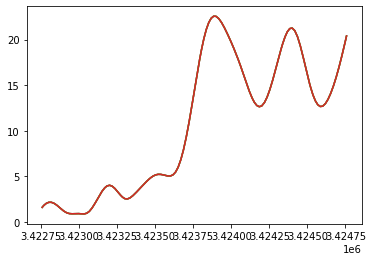

In [19]:


plt.plot(tracking.left_fl_v[start-1000:start+1000])
plt.plot(tracking.right_fl_v[start-1000:start+1000])
plt.plot(tracking.left_hl_v[start-1000:start+1000])
plt.plot(tracking.right_hl_v[start-1000:start+1000])

selected 53/1175


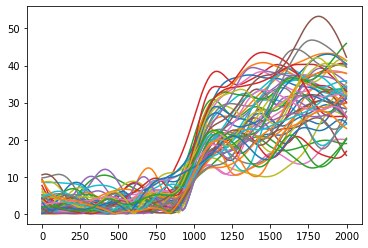

In [13]:
from fcutils.maths import derivative

is_moving = np.where(tracking.v > 9)[0]
moving = np.zeros_like(tracking.v)
moving[is_moving] = 1



move_start, move_stop = get_onset_offset(moving, .5)
v = tracking.v.values
d = derivative(v)

selected = 0
timepoints = []
for start in move_start:
    if start < 1000:
        continue
    # exclude baddies
    if np.mean(v[start-1000:start]) > 5:
        continue
    
    if np.mean(v[start:start+1000]) < 10:
        continue

    if np.max(v[start-1000:start]) >= 15:
        continue

    if np.min(v[start+200:start+1500]) < 10:
        continue

    if len(timepoints) and start - timepoints[-1] < 1000:
        continue

    # find precise start time based on derivative
    _d = d[start:start+250]
    shift = np.argmax(_d)
    precise_start = start + shift
    # last_neg = np.where(_d < 0)[0][-1]
    # precise_start = start - (1000 - last_neg)

    selected += 1
    timepoints.append(precise_start)
    plt.plot(tracking.v.values[precise_start-1000:precise_start+1000])
    # plt.plot(derivative(tracking.v.values[precise_start-1000:precise_start+1000])[1:])
print(f"selected {selected}/{len(move_start)}")

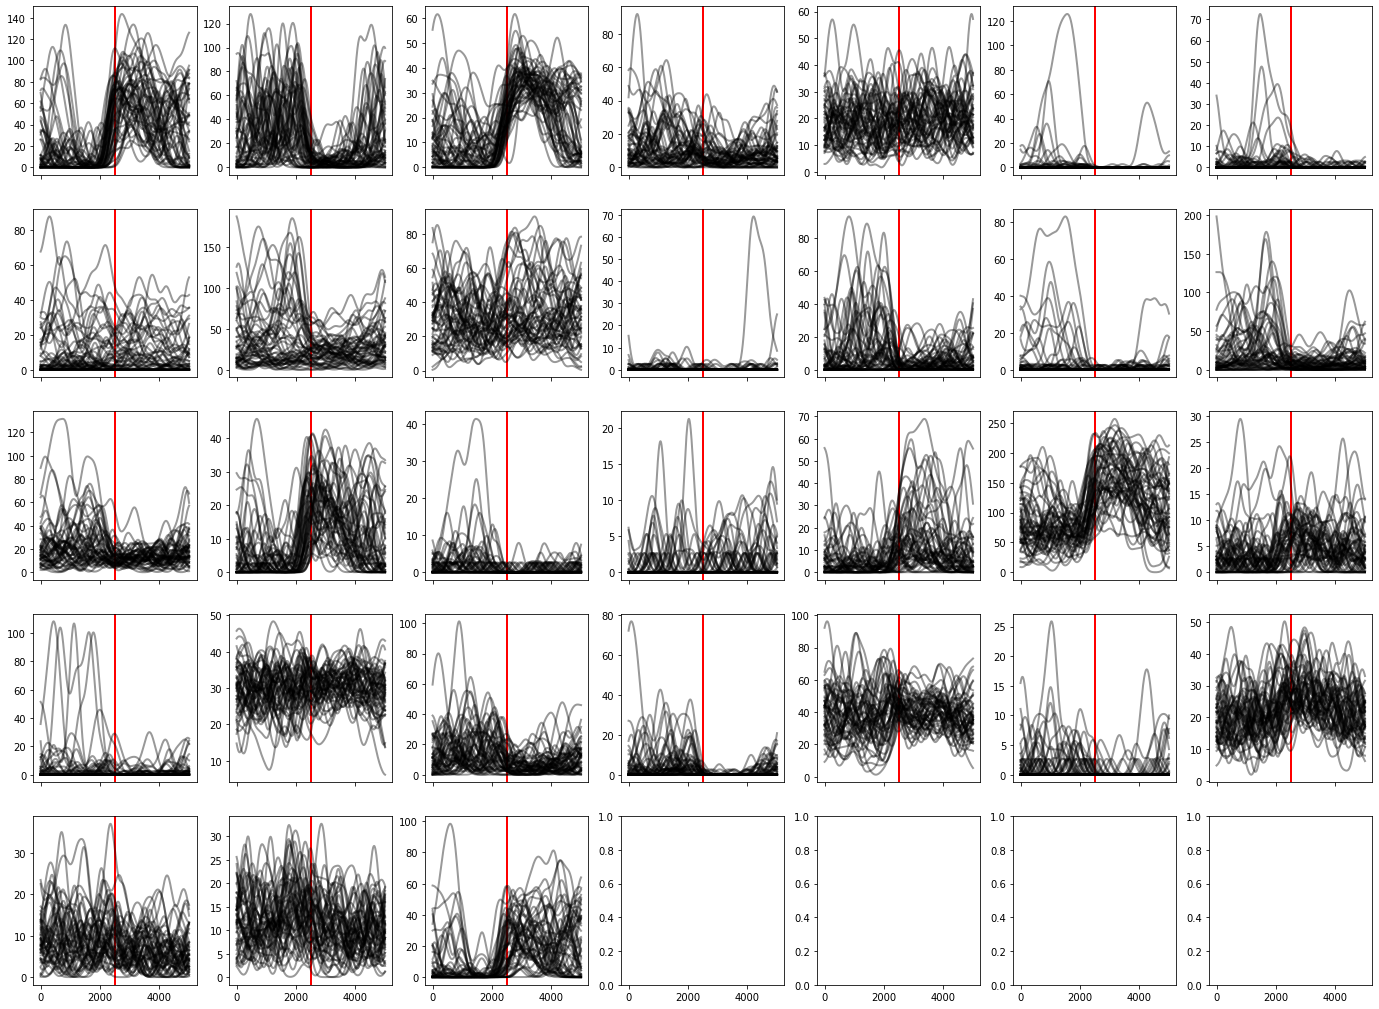

In [17]:
from fcutils.plot.figure import calc_nrows_ncols

figsize = (24, 18)
units_names = units.columns
nrows, ncols = calc_nrows_ncols(len(units_names), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=False)
axes = axes.flatten()


for name, ax in zip(units_names, axes):
    ax.axvline(2500, lw=2, color="r")
    for start in timepoints:
        ax.plot(units[name].values[start-2500:start+2500], color="k", lw=2, alpha=.4)